# Predicting User Demographic Characteristics Via Mobile Device Properties

## Abstract:

In a highly competitive and populated market like China, every interaction between a brand and consumer is crucial in creating a customer. Companies are now moving away from traditional methods of marketing to better understand and interact with their audience.

In this project, I will be building a model predicting the demographic characteristics of users based on their app usage, geo-location, and mobile device properties. In doing so this will help millions of developers and brand advertisers around the world to pursue data-driven marketing efforts that are more accurate and relevant to the consumers preferences.

The Data has been collected from TalkingData SDK integrated within mobile apps. TalkingData is China’s largest third-party mobile data platform and is integrated in more than 70% of the 500 million mobile devices active daily in China. 

Full recognition and consent from individual user of these apps have been obtained, and appropriate measures have been taken to protect the privacy of these individuals.

## The Introduction:

# Data Set Layout

In [749]:
print("# File Size:")
for f in os.listdir('input/'):
    if 'csv' in f:
        print(f.ljust(30) + str(round(os.path.getsize('input/' + f) / 1000000, 2)) + 'MB')

# File Size:
app_events.csv                1037.27MB
app_labels.csv                11.19MB
brand_translate.csv           0.0MB
events.csv                    195.43MB
gender_age_test.csv           2.28MB
gender_age_train.csv          2.37MB
label_categories.csv          0.02MB
phone_brand_device_model.csv  6.72MB


In [739]:
display(Image('images/files.png', width=525))

# Data Dictionary

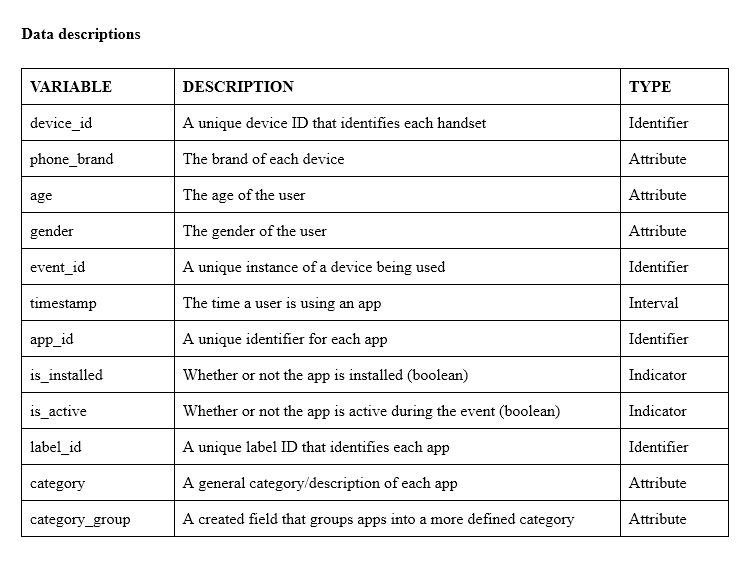

In [738]:
display(Image('images/dictionary.png', width=755))

In [731]:
import os
import re
import string
from IPython.display import display, Image

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)

import scipy
from scipy.sparse import csr_matrix, hstack

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# DATA SETS

In [522]:
device = pd.read_csv("input/phone_brand_device_model.csv")

In [279]:
events = pd.read_csv("input/events.csv")

In [280]:
app_events = pd.read_csv("input/app_events.csv")

In [281]:
app_labels = pd.read_csv("input/app_labels.csv")

In [282]:
label_categories = pd.read_csv("input/label_categories.csv")

In [283]:
group_test = pd.read_csv("input/gender_age_test.csv")

In [284]:
group_train = pd.read_csv("input/gender_age_train.csv")

# TRAIN.csv

In [286]:
group_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [289]:
group_train.shape

(74645, 4)

In [287]:
# Check for device duplicates
group_train.device_id.duplicated().value_counts()

False    74645
Name: device_id, dtype: int64

In [288]:
group_train.gender.value_counts()

M    47904
F    26741
Name: gender, dtype: int64

In [290]:
# Delete group column because of inaccuracies
del group_train['group']

In [291]:
group_train.head()

,device_id,gender,age
0,-8076087639492063270,M,35
1,-2897161552818060146,M,35
2,-8260683887967679142,M,35
3,-4938849341048082022,M,30
4,245133531816851882,M,30


In [292]:
# Males age 0-15
male_one = group_train[(group_train.gender == 'M') & (group_train.age >= 0) & (group_train.age < 15)]

In [294]:
male_one = male_one.assign(group = "M0-14")

In [297]:
# Males age 15-24
male_two = group_train[(group_train.gender == 'M') & (group_train.age >= 15) & (group_train.age < 25)]

In [298]:
male_two= male_two.assign(group = "M15-24")

In [302]:
# Males age 25-34
male_three = group_train[(group_train.gender == 'M') & (group_train.age >= 25) & (group_train.age < 35)]

In [303]:
male_three = male_three.assign(group = "M25-34")

In [307]:
# Males age 35-44
male_four = group_train[(group_train.gender == 'M') & (group_train.age >= 35) & (group_train.age < 45)]

In [308]:
male_four = male_four.assign(group = "M35-44")

In [311]:
# Males age 45 and older
male_five = group_train[(group_train.gender == 'M') & (group_train.age > 44)]

In [312]:
male_five = male_five.assign(group = "M45+")

In [422]:
print("## Males Ages Percent of Total")
print("Percent of Males Ages 0-14:   ", len(male_one) / len(group_train)*100)
print("Percent of Males Ages 15-24: ", len(male_two) / len(group_train)*100)
print("Percent of Males Ages 25-34: ", len(male_three) / len(group_train)*100)
print("Percent of Males Ages 35-44: ", len(male_four) / len(group_train)*100)
print("Percent of Males Ages 45+:    ", len(male_five) / len(group_train)*100)

## Males Ages Percent of Total
Percent of Males Ages 0-14:    0.06430437403710898
Percent of Males Ages 15-24:  15.721079777614039
Percent of Males Ages 25-34:  31.060352334382745
Percent of Males Ages 35-44:  11.253265456494072
Percent of Males Ages 45+:     6.076763346506799


In [314]:
# Females age 0-14
female_one = group_train[(group_train.gender == 'F') & (group_train.age >= 0) & (group_train.age < 15)]

In [315]:
female_one = female_one.assign(group = "F0-14")

In [317]:
# Females age 15-24
female_two = group_train[(group_train.gender == 'F') & (group_train.age >= 15) & (group_train.age < 25)]

In [318]:
female_two = female_two.assign(group = "F15-24")

In [320]:
# Females age 25-34
female_three = group_train[(group_train.gender == 'F') & (group_train.age >= 25) & (group_train.age < 35)]

In [321]:
female_three = female_three.assign(group = "F25-34")

In [323]:
# Females age 35-44
female_four = group_train[(group_train.gender == 'F') & (group_train.age >= 35) & (group_train.age < 45)]

In [324]:
female_four = female_four.assign(group = "F35-44")

In [326]:
# Females age 45 and older
female_five = group_train[(group_train.gender == 'F') & (group_train.age > 44)]

In [328]:
female_five = female_five.assign(group = "F45+")

In [424]:
print("## Females Ages Percent of Total")
print("Percent of Females Ages 0-14:   ", len(female_one) / len(group_train)*100)
print("Percent of Females Ages 15-24:  ", len(female_two) / len(group_train)*100)
print("Percent of Females Ages 25-34: ", len(female_three) / len(group_train)*100)
print("Percent of Females Ages 35-44:  ", len(female_four) / len(group_train)*100)
print("Percent of Females Ages 45+:    ", len(female_five) / len(group_train)*100)

## Females Ages Percent of Total
Percent of Females Ages 0-14:    0.04019023377319311
Percent of Females Ages 15-24:   8.359568624824169
Percent of Females Ages 25-34:  16.658851898988548
Percent of Females Ages 35-44:   6.131689999330163
Percent of Females Ages 45+:     4.633933954049166


In [329]:
frames = [male_one, male_two, male_three, male_four, male_five,
         female_one, female_two, female_three, female_four, female_five]

In [330]:
group_train = pd.concat(frames)

In [331]:
group_train.head()

,device_id,gender,age,group
2965,-3385849910825246878,M,13,M0-14
10385,3553057874282315257,M,1,M0-14
11510,8795434320644947601,M,12,M0-14
11793,6345362808844118344,M,14,M0-14
14760,5081483191514219485,M,13,M0-14


In [332]:
# Double Check 
len(group_train)

74645

# GROUP_TRAIN.csv

In [224]:
# Save to .CSV
group_train.to_csv('group_train.csv')

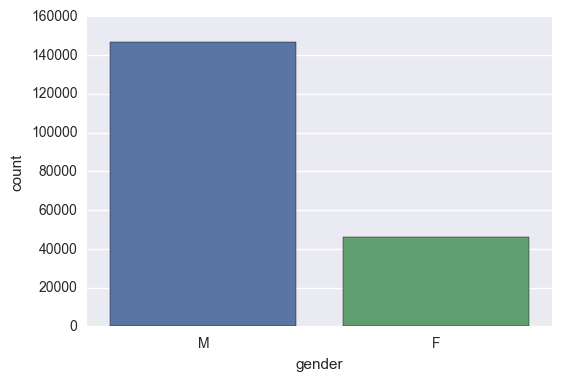

In [753]:
display(Image('images/malefemale.png', width=554))

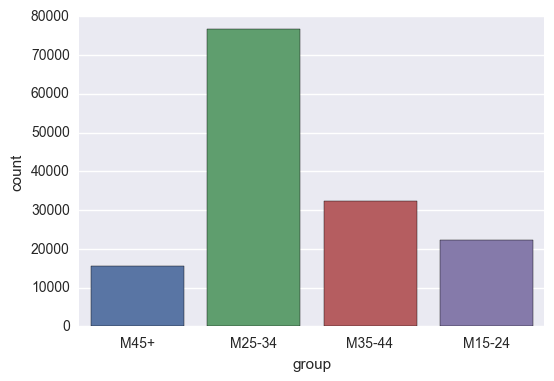

In [754]:
display(Image('images/maleschina.png', width=554))

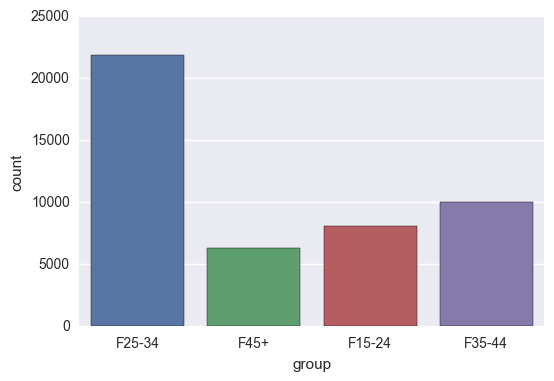

In [755]:
display(Image('images/femaleschina.png', width=554))

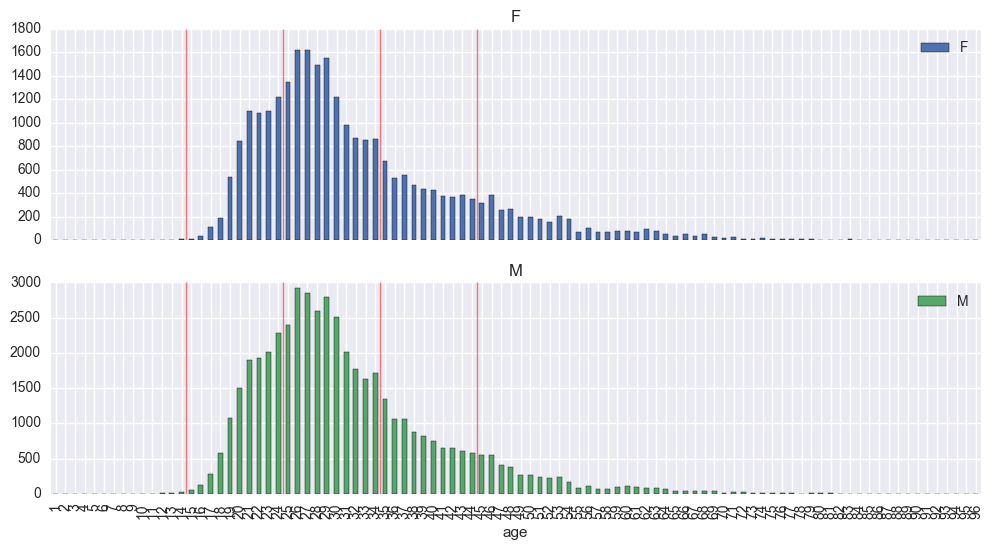

In [230]:
c = group_train.groupby(['age','gender']).size().unstack().reindex(index=np.arange(group_train.age.min(), group_train.age.max()+1)).fillna(0)
ax1, ax2 = c.plot(kind='bar',figsize=(12,6),subplots=True);
ax1.vlines(np.array([14,24,34,44])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([14,24,34,44])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

# TEST

In [244]:
group_test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [245]:
group_test.device_id.duplicated().value_counts()

False    112071
Name: device_id, dtype: int64

In [551]:
group_test.device_id.duplicated().value_counts()

False    112071
Name: device_id, dtype: int64

# DEVICE

In [523]:
# Check for duplicated device ID's
device.device_id.duplicated().value_counts()

False    186716
True        529
Name: device_id, dtype: int64

In [524]:
# Drop duplicates except for the first occurance from column 'device_id'
device = device.drop_duplicates(subset='device_id', keep='first')

In [525]:
device.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [526]:
# Translate
device = device.rename(columns={'phone_brand' : 'device_brand'})

In [527]:
device.device_brand = device.device_brand.str.lower()

In [528]:
translate = pd.read_csv("input/brand_translate.csv")

In [529]:
k = translate.chinese.tolist()
v = translate.english.tolist()
translate = dict(zip(k,v))

In [530]:
device = device.replace({"device_brand": translate,"device_model": translate})

In [535]:
device.head()

,device_id,device_brand,device_model
0,-8890648629457979026,xiaomi,red rice
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,sugar,fashion mobile phone
4,-5019277647504317457,samsung,Galaxy Note 2


In [536]:
# pandas.DataFrame.groupby:
# Group series using mapper (dict or key function, apply given function to group, return result as series) 
# or by a series of columns.
# pandas.Series.nunique : Return number of unique elements in the object.
c = device.groupby('device_model')['device_brand'].apply(pd.Series.nunique)
c.value_counts()

1    1545
2      43
3       8
4       3
Name: device_brand, dtype: int64

In [537]:
# sklearn.fit_transform: Fit label encoder and return encoded labels.
device['brand'] = LabelEncoder().fit_transform(device.device_brand)
device['model'] = LabelEncoder().fit_transform(device.device_model)

# Brand and Model Popularity

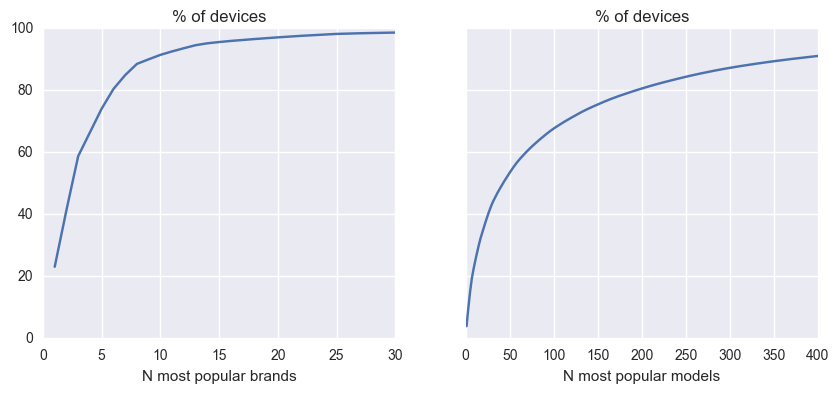

In [351]:
c = device.brand.value_counts()
s = c.cumsum()/c.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(np.arange(s.shape[0])+1, s.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_title('% of devices');
c = device.model.value_counts()
s = c.cumsum()/c.sum()
ax2.plot(np.arange(s.shape[0])+1, s.values*100)
ax2.set_xlim(0,400)
ax2.set_xlabel('N most popular models')
ax2.set_title('% of devices');

# Gender Ratio by Device

In [541]:
train = training.merge(device[['device_id','brand','model']], how='left',on='device_id')

In [547]:
train.to_csv('train_set.csv')

In [542]:
train.head()

,device_id,device_brand,device_model,gender,age,group,brand,model
0,-8890648629457979026,xiaomi,red rice,M,33,M25-34,66,1438
1,1277779817574759137,xiaomi,MI 2,M,26,M25-34,66,749
2,-5019277647504317457,samsung,Galaxy Note 2,F,32,F25-34,57,536
3,3238009352149731868,huawei,Mate,F,30,F25-34,26,774
4,-5827952925479472594,xiaomi,MI One Plus,M,30,M25-34,66,758


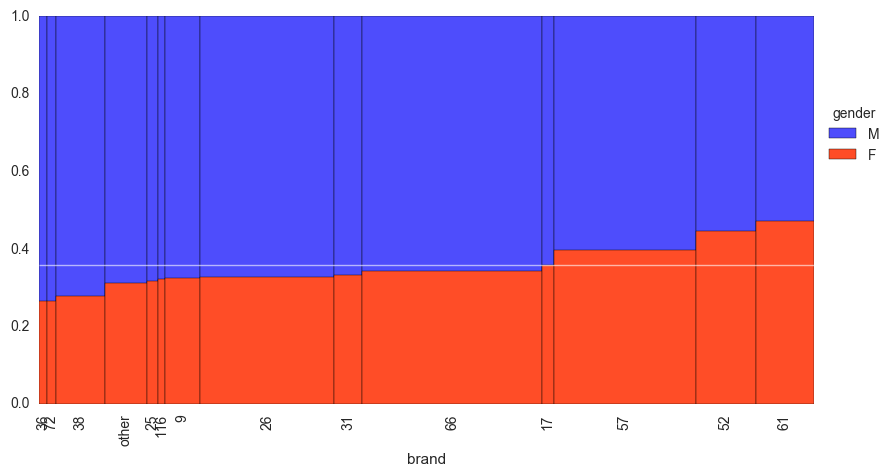

In [544]:
ax = plot_by(train, 'gender','brand')

In [730]:
print("Favorite Brands by Women: '三星', 'OPPO', 'vivo")

Favorite Brands by Women: '三星', 'OPPO', 'vivo


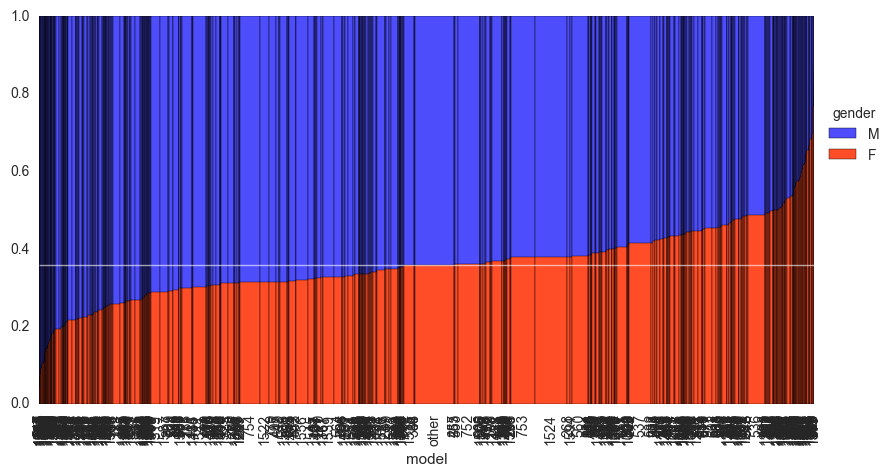

In [358]:
ax = plot_by(train, 'gender','model')

# Age Distribution by Top 10 Devices

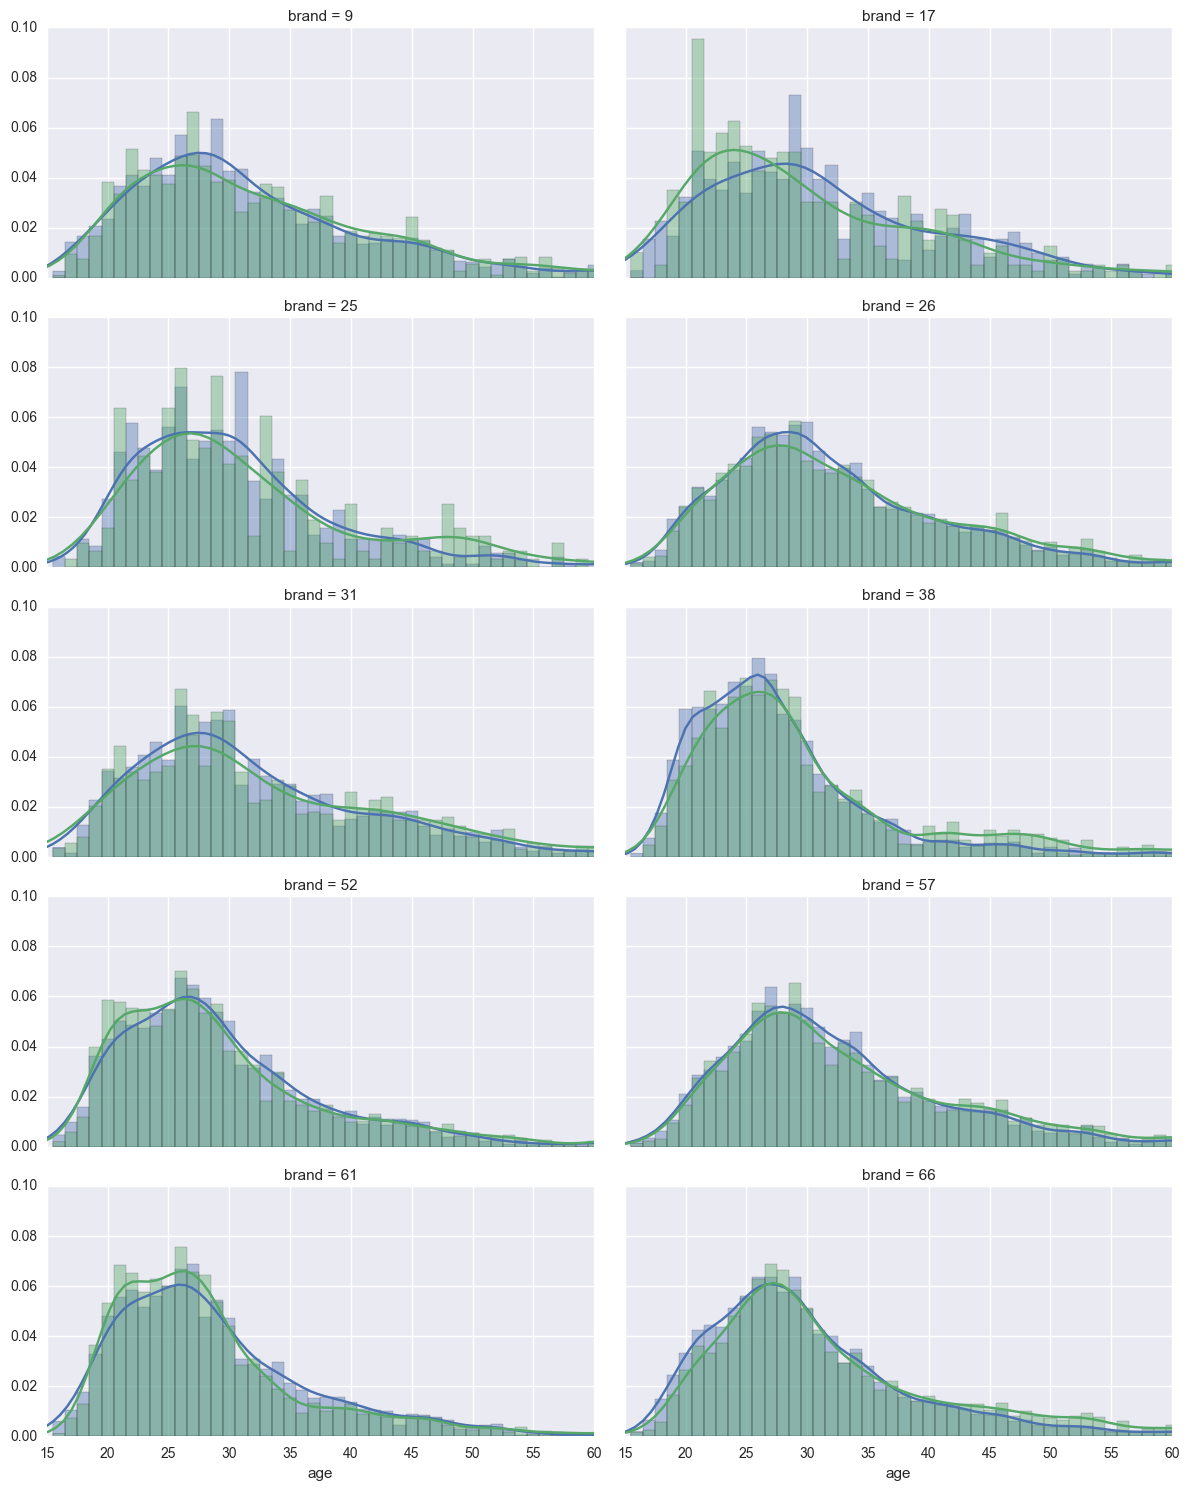

In [743]:
display(Image('images/bydevice.png', width=920))

# Age Distribution by Top 10 Device Model

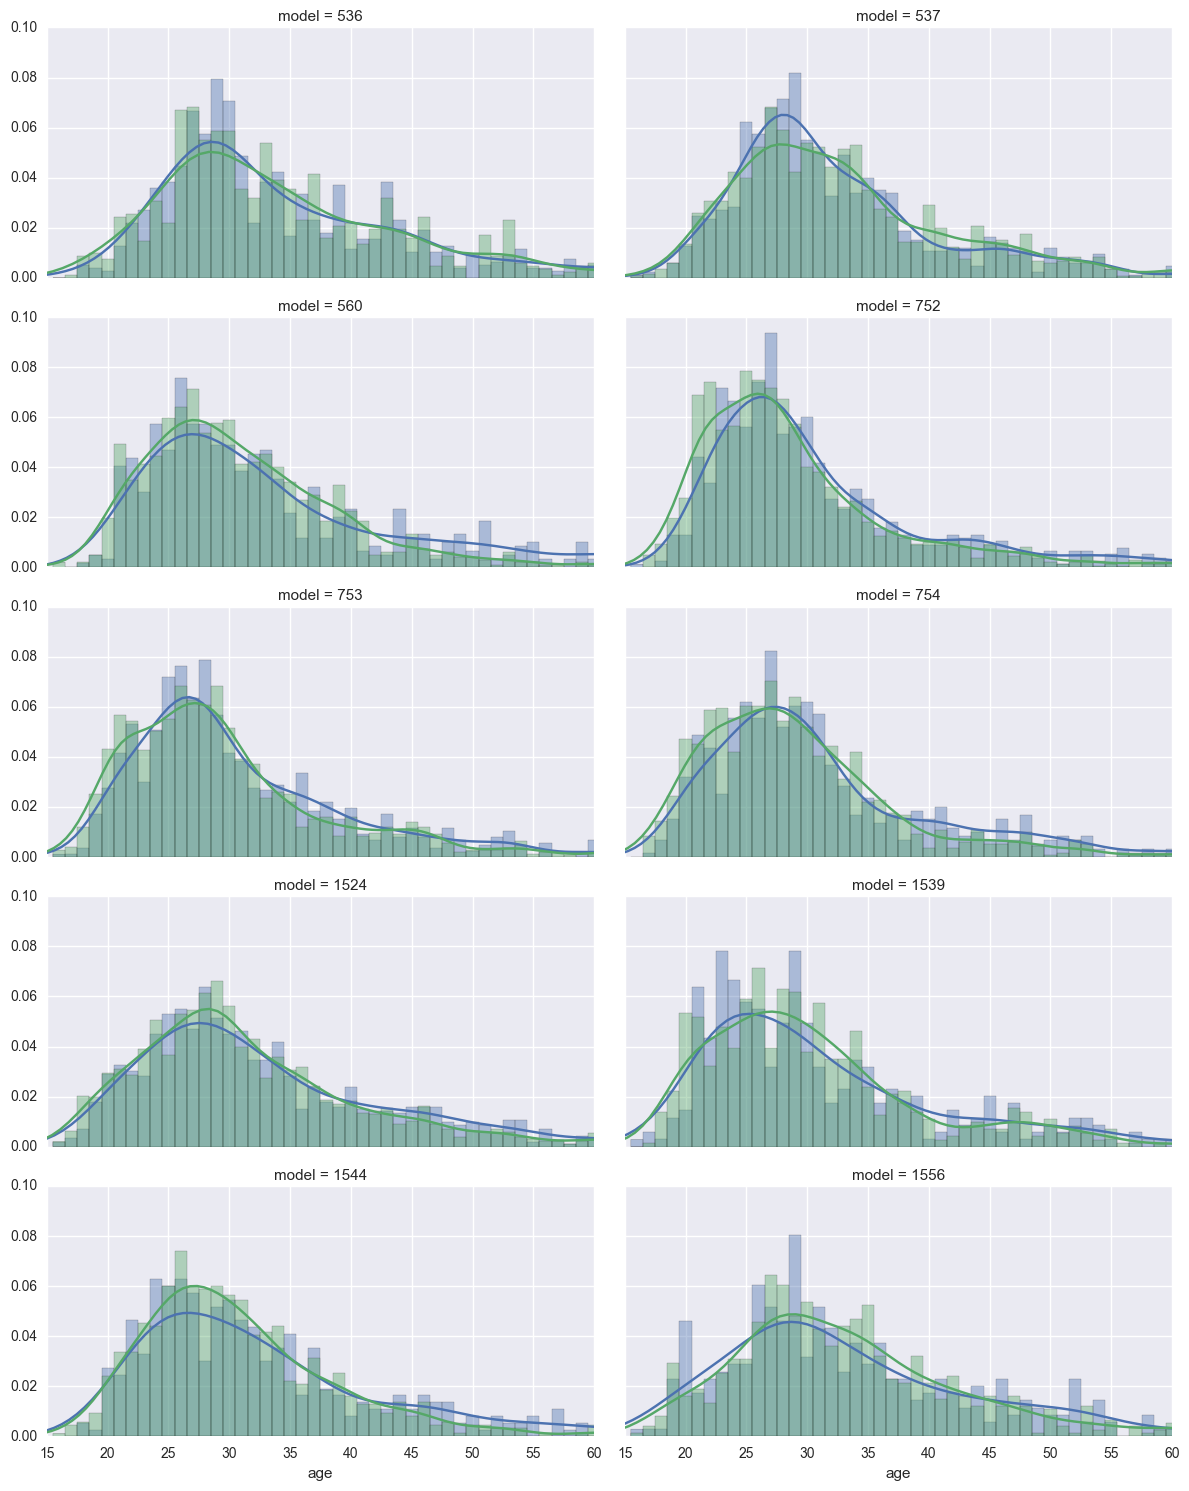

In [746]:
display(Image('images/bymodel.png', width=920))

# Predict Group by Device

In [729]:
# pandas.DataFrame.set_index: Set the DataFrame index (row labels) using one or more existing columns. 
# By default yields a new object.

grouptrain = pd.read_csv('input/gender_age_train.csv', index_col='device_id')
grouptest = pd.read_csv('input/gender_age_test.csv', index_col = 'device_id')
devices = pd.read_csv('input/phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
devices = devices.drop_duplicates('device_id',keep='first').set_index('device_id')
event = pd.read_csv('input/events.csv', parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv('input/app_events.csv', usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})
applabels = pd.read_csv('input/app_labels.csv')

In [679]:
grouptrain['train_row'] = np.arange(len(grouptrain))
grouptest['test_row'] = np.arange(len(grouptest))

In [683]:
devices.head()

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2


In [684]:
devices = devices.rename(columns={'phone_brand' : 'device_brand'})

In [685]:
devices.device_brand = devices.device_brand.str.lower()

In [686]:
translate = pd.read_csv("input/brand_translate.csv")

In [687]:
k = translate.chinese.tolist()
v = translate.english.tolist()
translate = dict(zip(k,v))

In [688]:
devices = devices.replace({"device_brand": translate,"device_model": translate})

In [689]:
devices.head()

,device_brand,device_model
device_id,,
-8890648629457979026,xiaomi,red rice
1277779817574759137,xiaomi,MI 2
5137427614288105724,samsung,Galaxy S4
3669464369358936369,sugar,fashion mobile phone
-5019277647504317457,samsung,Galaxy Note 2


In [690]:
# sklearn.preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1
# Transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
# Fit label encoder

le_brand = LabelEncoder().fit(devices.device_brand)

In [691]:
# Transform labels to normalized encoding.

devices['brand'] = le_brand.transform(devices['device_brand'])

In [692]:
grouptrain["brand"] = devices["brand"]
grouptest['brand'] = devices['brand']

In [720]:
# scipy.sparse.csr_matrix: 
# Compressed Sparse Row matrix
# csr_matrix((data, indices, indptr), [shape=(M, N)])
# is the standard CSR representation where the column indices 
# for row i are stored in indices[indptr[i]:indptr[i+1]] and their corresponding values 
# are stored in data[indptr[i]:indptr[i+1]]. If the shape parameter is not supplied, the matrix dimensions 
# are inferred from the index arrays.

Xtrain_brand = csr_matrix((np.ones(len(grouptrain)), (grouptrain.train_row, grouptrain.brand)))
Xtest_brand = csr_matrix((np.ones(len(grouptest)), (grouptest.test_row, grouptest.brand)))

In [695]:
print('Brand features: train shape {}, test shape {}'.format(Xbrand_train.shape, Xbrand_test.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [696]:
# pandas.Series.str.cat: Concatenate strings in the Series/Index with given separator.

mobile = devices.device_brand.str.cat(devices.device_model)

In [697]:
# Fit label encoder

le_model = LabelEncoder().fit(mobile)

In [698]:
# Transform labels to normalized encoding.

devices['model'] = le_model.transform(mobile)

In [699]:
grouptrain['model'] = devices['model']
grouptest['model'] = devices['model']

In [700]:
# scipy.sparse.csr_matrix: 
# Compressed Sparse Row matrix
# csr_matrix((data, indices, indptr), [shape=(M, N)])
# is the standard CSR representation where the column indices 
# for row i are stored in indices[indptr[i]:indptr[i+1]] and their corresponding values 
# are stored in data[indptr[i]:indptr[i+1]]. If the shape parameter is not supplied, the matrix dimensions 
# are inferred from the index arrays.

# np.ones: Return a new array of given shape and type, filled with ones.

Xtrain_model = csr_matrix((np.ones(grouptrain.shape[0]), 
                       (grouptrain.train_row, grouptrain.model)))
Xtest_model = csr_matrix((np.ones(grouptest.shape[0]), 
                       (grouptest.test_row, grouptest.model)))

In [701]:
print('Model features: train shape {}, test shape {}'.format(Xtrain_model.shape, Xtest_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [702]:
appevents.head(1)

,event_id,app_id,is_active
0,2,5927333115845830913,True


In [703]:
# sklearn.preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1
# Transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

# Fit label encoder
# Transform labels to normalized encoding.

le_app = LabelEncoder().fit(appevent.app_id)
appevents['app'] = le_app.transform(appevents.app_id)

In [704]:
# classes_ 
# Holds the label for each class.

n_appclasses = len(le_app.classes_)

In [705]:
# pandas.DataFrame.merge:
# Merge DataFrame objects by performing a database-style join operation by columns or indexes.

# left: use only keys from left frame (SQL: left outer join)

# left_on : label or list, or array-like
# Field names to join on in left DataFrame. 
# Can be a vector or list of vectors of the length of the DataFrame to use a particular vector 
# as the join key instead of columns

# right_index : boolean, default False
# Use the index from the right DataFrame as the join key. Same caveats as left_index

# left_index : boolean, default False
# Use the index from the left DataFrame as the join key(s). 
# If it is a MultiIndex, the number of keys in the other DataFrame (either the index or a number of columns) 
# must match the number of levels

# pandas.DataFrame.groupby:
# Group series using mapper (dict or key function, apply given function to group, return result as series) 
# or by a series of columns.

# pandas.core.groupby.DataFrameGroupBy.agg:
# Aggregate using input function or dict of {column -> function}

# pandas.DataFrame.reset_index: 
# For DataFrame with multi-level index, return new DataFrame with labeling information in the columns 
# under the index names, defaulting to ‘level_0’, ‘level_1’, etc. if any are None. 
# For a standard index, the index name will be used (if set), otherwise a default ‘index’ or ‘level_0’ 
# (if ‘index’ is already taken) will be used.

device_apps = (appevents.merge(event[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(grouptrain[['train_row']], how='left', left_index=True, right_index=True)
                       .merge(grouptest[['test_row']], how='left', left_index=True, right_index=True)
                       .reset_index())

In [707]:
# scipy.sparse.csr_matrix: 
# Compressed Sparse Row matrix
# csr_matrix((data, indices, indptr), [shape=(M, N)])
# is the standard CSR representation where the column indices 
# for row i are stored in indices[indptr[i]:indptr[i+1]] and their corresponding values 
# are stored in data[indptr[i]:indptr[i+1]]. If the shape parameter is not supplied, the matrix dimensions 
# are inferred from the index arrays.

# np.ones: Return a new array of given shape and type, filled with ones.

dapp = device_apps.dropna(subset=['train_row'])
Xtrain_app = csr_matrix((np.ones(dapp.shape[0]), (dapp.train_row, dapp.app)), 
                      shape=(grouptrain.shape[0],n_appclasses))
dapp = device_apps.dropna(subset=['test_row'])
Xtest_app = csr_matrix((np.ones(dapp.shape[0]), (dapp.test_row, dapp.app)), 
                      shape=(grouptest.shape[0],n_appclasses))

In [710]:
print('Apps data: train shape {}, test shape {}'.format(Xtrain_app.shape, Xtest_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [712]:
# sklearn.preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1
# Transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

# Fit label encoder
# Transform labels to normalized encoding.

# classes_ 
# Holds the label for each class.

applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = le_app.transform(applabels.app_id)
le_labels = LabelEncoder().fit(applabels.label_id)
applabels['label'] = le_labels.transform(applabels.label_id)
n_labelsclasses = len(le_labels.classes_)

In [713]:
# pandas.DataFrame.merge:
# Merge DataFrame objects by performing a database-style join operation by columns or indexes.

# left: use only keys from left frame (SQL: left outer join)

# left_on : label or list, or array-like
# Field names to join on in left DataFrame. 
# Can be a vector or list of vectors of the length of the DataFrame to use a particular vector 
# as the join key instead of columns

# right_index : boolean, default False
# Use the index from the right DataFrame as the join key. Same caveats as left_index

# left_index : boolean, default False
# Use the index from the left DataFrame as the join key(s). 
# If it is a MultiIndex, the number of keys in the other DataFrame (either the index or a number of columns) 
# must match the number of levels

# pandas.DataFrame.groupby:
# Group series using mapper (dict or key function, apply given function to group, return result as series) 
# or by a series of columns.

# pandas.core.groupby.DataFrameGroupBy.agg:
# Aggregate using input function or dict of {column -> function}

# pandas.DataFrame.reset_index: 
# For DataFrame with multi-level index, return new DataFrame with labeling information in the columns 
# under the index names, defaulting to ‘level_0’, ‘level_1’, etc. if any are None. 
# For a standard index, the index name will be used (if set), otherwise a default ‘index’ or ‘level_0’ 
# (if ‘index’ is already taken) will be used.

device_labels = (device_apps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(grouptrain[['train_row']], how='left', left_index=True, right_index=True)
                .merge(grouptest[['test_row']], how='left', left_index=True, right_index=True)
                .reset_index())
device_labels.head()

,device_id,label,size,train_row,test_row
0,-9222956879900151005,117,1,37382.0,NaN
1,-9222956879900151005,120,1,37382.0,NaN
2,-9222956879900151005,126,1,37382.0,NaN
3,-9222956879900151005,138,2,37382.0,NaN
4,-9222956879900151005,147,2,37382.0,NaN


In [716]:
# scipy.sparse.csr_matrix: 
# Compressed Sparse Row matrix
# csr_matrix((data, indices, indptr), [shape=(M, N)])
# is the standard CSR representation where the column indices 
# for row i are stored in indices[indptr[i]:indptr[i+1]] and their corresponding values 
# are stored in data[indptr[i]:indptr[i+1]]. If the shape parameter is not supplied, the matrix dimensions 
# are inferred from the index arrays.

# np.ones: Return a new array of given shape and type, filled with ones.

dapp = device_labels.dropna(subset=['train_row'])
Xtrain_label = csr_matrix((np.ones(dapp.shape[0]), (dapp.train_row, dapp.label)), 
                      shape=(grouptrain.shape[0],n_labelsclasses))
dapp = device_labels.dropna(subset=['test_row'])
Xtest_label = csr_matrix((np.ones(dapp.shape[0]), (dapp.test_row, dapp.label)), 
                      shape=(grouptest.shape[0],n_labelsclasses))

In [718]:
print('Labels data: train shape {}, test shape {}'.format(Xtrain_label.shape, Xtest_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [721]:
# scipy.sparse.hstack:
# Stack sparse matrices horizontally (column wise)

# format : str
# sparse format of the result (e.g. “csr”) by default an appropriate sparse matrix format is returned. 
# This choice is subject to change.

Xtrain = hstack((Xtrain_brand, Xtrain_model, Xtrain_app, Xtrain_label), format='csr')
Xtest =  hstack((Xtest_brand, Xtest_model, Xtest_app, Xtest_label), format='csr')

In [722]:
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [723]:
# sklearn.preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1
# Transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

# Fit label encoder
# Transform labels to normalized encoding.

# classes_ 
# Holds the label for each class.

le = LabelEncoder().fit(grouptrain.group)
y = le.transform(grouptrain.group)
n_classes = len(le.classes_)

In [726]:
# sklearn.linear_model.LogisticRegression
# This class implements regularized logistic regression using the ‘liblinear’ library, ‘newton-cg’, 
# ‘sag’ and ‘lbfgs’ solvers. It can handle both dense and sparse input. 
# Use C-ordered arrays or CSR matrices containing 64-bit floats for optimal performance; 
# any other input format will be converted (and copied).

# The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation. 
# The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty.

# C : float, default: 1.0
# Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization.

# multi_class : str, {‘ovr’, ‘multinomial’}, default: ‘ovr’
# Multiclass option can be either ‘ovr’ or ‘multinomial’. 
# If the option chosen is ‘ovr’, then a binary problem is fit for each label. 
# Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
# Works only for the ‘newton-cg’, ‘sag’ and ‘lbfgs’ solver.

# solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}, default: ‘liblinear’
# For multiclass problems, only ‘newton-cg’, ‘sag’ and ‘lbfgs’ handle
# multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

# ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty.

# clf.fit(X, y[, sample_weight]): Fit the model according to the given training data.

# clf.predict_proba(X): Probability estimates.

clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = grouptest.index, columns=le.classes_)
pred.head()

,F0-14,F15-24,F25-34,F35-44,F45+,M0-14,M15-24,M25-34,M35-44,M45+
device_id,,,,,,,,,,
1002079943728939269,0.000128,0.002477,0.046471,0.015864,0.057265,0.000114,0.043639,0.367115,0.212196,0.254731
-1547860181818787117,0.000289,0.013684,0.115503,0.064865,0.133922,0.000246,0.028597,0.304559,0.221565,0.116771
7374582448058474277,0.000677,0.036364,0.250321,0.122706,0.071625,0.001761,0.031076,0.289110,0.105034,0.091327
-6220210354783429585,0.000263,0.005487,0.025586,0.052427,0.156658,0.000212,0.050423,0.468722,0.151921,0.088301
-5893464122623104785,0.000389,0.061916,0.170750,0.041056,0.035961,0.000571,0.153377,0.384898,0.109730,0.041353
